#  Detection of wind outages over W Europe and link with weather regime

In [1]:
import netCDF4
import xarray as xr
import numpy as np

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib.pyplot as plt
import matplotlib.path as mpath
from matplotlib.ticker import FixedLocator

import pandas as pd

import datetime

## Getting wind speed using CDO

Computing wind speed norm from u and v components

Nearly the same for oceans

## Opening data and preparing domain

In [2]:
ws = xr.open_dataset('./data/wind10_eur_19790101_20191231.nc')

In [3]:
lat  = ws.latitude.values
lon  = ws.longitude.values
latS=30
latN=80
lonW=-20
lonE=30
projection = ccrs.Orthographic(central_longitude=(lonW+lonE)/2, central_latitude=(latS+latN)/2)
bounds = [(lonW, lonE, latS, latN)]

def make_boundary_path(lon,lat):
    lons,lats=np.meshgrid(lon,lat)
    boundary_path = np.array([lons[-1,:],lats[-1,:]])
    boundary_path = np.append(boundary_path,np.array([lons[::-1,-1],lats[::-1,-1]]),axis=1)
    boundary_path = np.append(boundary_path,np.array([lons[1,::-1],lats[1,::-1]]),axis=1)
    boundary_path = np.append(boundary_path,np.array([lons[:,1],lats[:,1]]),axis=1)
    boundary_path = mpath.Path(np.swapaxes(boundary_path, 0, 1))
    return boundary_path

# Wind outage detection using Wind Speed Index (WSI) over western Europe

In [4]:
#WSI AREA
latS_zoom=37
latN_zoom=60
lonW_zoom=-10
lonE_zoom=25
hres = 0.25 #degree
zoom_bounds = [(lonW_zoom, lonE_zoom, latS_zoom, latN_zoom)]
lon_zoom = np.arange(lonW_zoom,lonE_zoom+hres,hres)
lat_zoom = np.arange(latS_zoom,latN_zoom+hres,hres)

#sub WSI areas
latS_zoom_subN=45
latN_zoom_subS=45
lat_zoom_subN = np.arange(latS_zoom_subN,latN_zoom+hres,hres)
lat_zoom_subS = np.arange(latS_zoom,latN_zoom_subS+hres,hres)

In [5]:
#better x ticks
def dayofyear_todate(dayofyear) :
    offset_bisextyear = 3*365
    return f'{datetime.date.fromordinal(offset_bisextyear + dayofyear).day:02d}/{datetime.date.fromordinal(offset_bisextyear + dayofyear).month:02d}'
dates = [dayofyear_todate(dayofyear) for dayofyear in range(1,367)]
x_locator = FixedLocator([14,45,74,105,135,166,196,227,258,288,319,349])

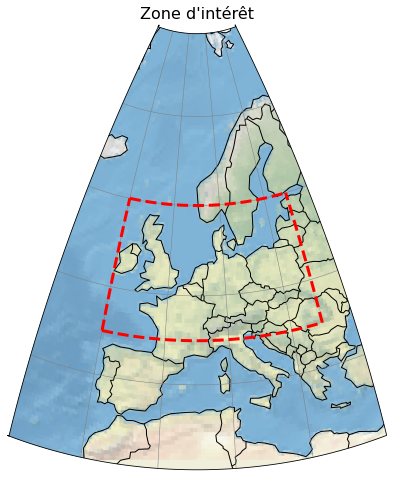

In [6]:
fig = plt.figure(figsize=(11, 8))

ax = fig.add_subplot(1, 1, 1, projection=projection)
ax.set_title("Zone d'intérêt", fontsize = 16)
ax.stock_img()
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.BORDERS)
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
boundary_path = make_boundary_path(lon, lat)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())
ax.plot([lonW_zoom]*len(lat_zoom_subN), lat_zoom_subN, transform=ccrs.PlateCarree(), color = 'red', ls = '--', lw = 3)
ax.plot([lonE_zoom]*len(lat_zoom_subN), lat_zoom_subN, transform=ccrs.PlateCarree(), color = 'red', ls = '--', lw = 3)
ax.plot(lon_zoom, [latN_zoom]*len(lon_zoom), transform=ccrs.PlateCarree(), color = 'red', ls = '--', lw = 3)
ax.plot(lon_zoom, [latS_zoom_subN]*len(lon_zoom), transform=ccrs.PlateCarree(), color = 'red', ls = '--', lw = 3)

ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='gray', linestyle='-')
plt.savefig('figs_wind/N_box/area.jpeg')
plt.show()

=================================================================================================================

Selecting data over this chosen area

In [7]:
ws_zoom = ws.sel(longitude = lon_zoom, latitude = lat_zoom_subN).ws.fillna(0).to_dataset()

### Definition of WSI (over land) and first visualisations

#### WSI using a simple spatial mean

Computing spatial average over land for each timestep ie. comuting Wind Speed Index (WSI) weighted by ${cos(lat)}$ to prevent gridpoint stretch biais.

In [8]:
wgts = (np.cos(np.deg2rad(ws_zoom.latitude)))

In [9]:
ws_zoom_weighted = ws_zoom.weighted(wgts)

In [10]:
ws_index = ws_zoom_weighted.mean(dim = ['longitude','latitude'])

=================================================================================================================

Daily climatological mean of WSI over the full period (1980-2019)

In [11]:
ws_index_dmean = ws_index.groupby('time.dayofyear').mean('time')

=================================================================================================================

Computing a 30-day rolling mean of the previously computed WSI daily mean ie. a smooth daily climatology of WSI

In [12]:
ws_index_day_mean = xr.concat([
    ws_index_dmean.roll(dayofyear=150, roll_coords= True).ws.rolling(dayofyear=30, center=True).mean().roll(dayofyear=-150, roll_coords= True)[:15],
    ws_index_dmean.ws.rolling(dayofyear=30, center=True).mean().dropna('dayofyear'),
    ws_index_dmean.roll(dayofyear=150, roll_coords= True).ws.rolling(dayofyear=30, center=True).mean().roll(dayofyear=-150, roll_coords= True)[-14:]],
    dim = 'dayofyear')


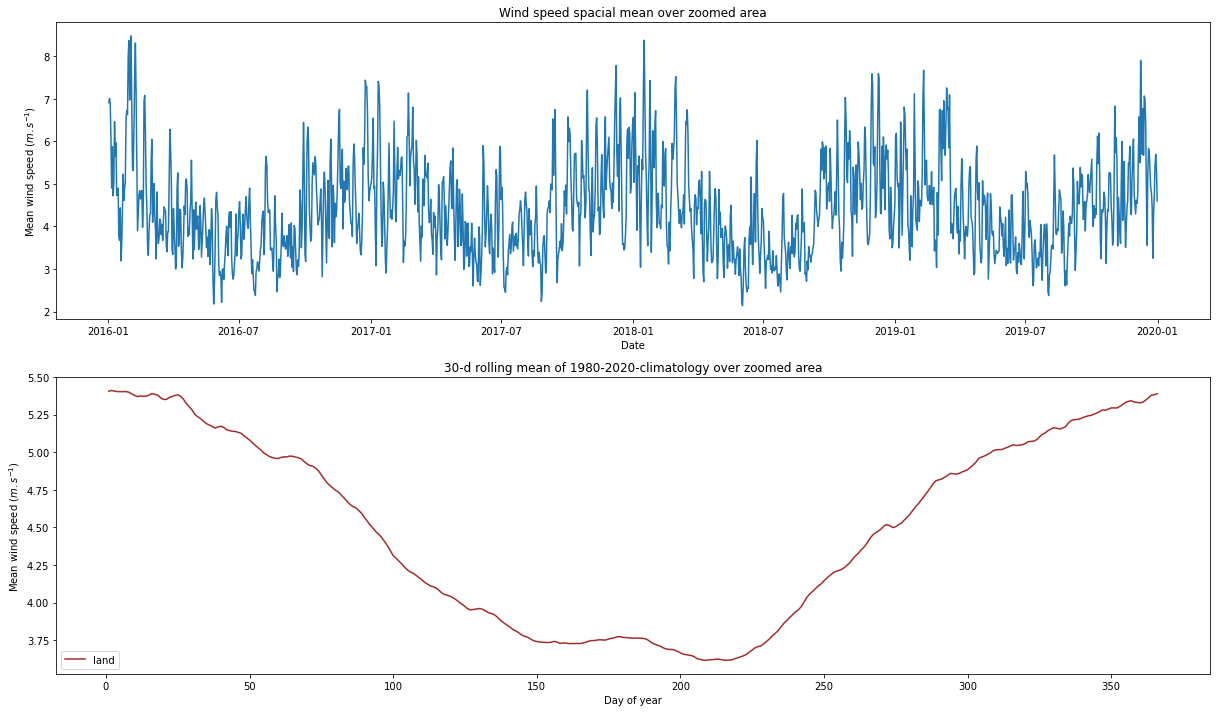

In [13]:
fig = plt.figure(figsize=(17, 10))

ax = fig.add_subplot(2, 1, 1)
ax.set_title('Wind speed spacial mean over zoomed area')
ax.plot(ws_index.time.values[-365*4:], ws_index.ws[-365*4:])
ax.set_xlabel('Date')
ax.set_ylabel('Mean wind speed ($m.s^{-1}$)')

ax = fig.add_subplot(2, 1, 2)
ax.set_title('30-d rolling mean of 1980-2020-climatology over zoomed area')
ax.plot(ws_index_day_mean.dayofyear, ws_index_day_mean, color = 'brown', label = 'land')
ax.set_xlabel('Day of year')
ax.set_ylabel('Mean wind speed ($m.s^{-1}$)')
ax.legend()

plt.tight_layout()
plt.show()

##### Comments
High frequence (daily) variability and seasonnal cycle appear, isolation of the seasonnal cycle with a 30-d rolling mean.

=================================================================================================================

Let's take a look on high frequence variability by substracting the seasonnal cycle.

In [14]:
ws_index_danom = ws_index.ws.groupby('time.dayofyear') - ws_index_day_mean

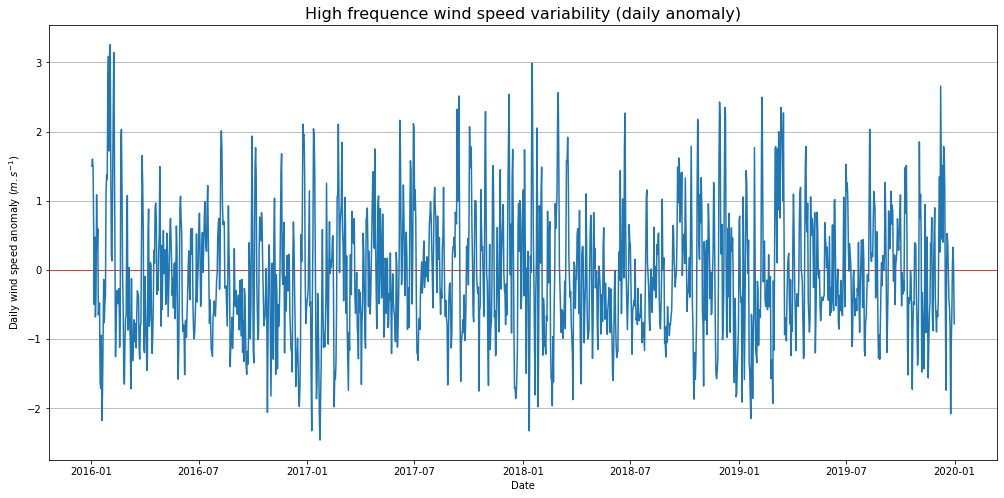

In [15]:
fig = plt.figure(figsize=(17, 8))
ws_index_danom_zoom = ws_index_danom[-365*4:]

ax = fig.add_subplot(1, 1, 1)
ax.set_title('High frequence wind speed variability (daily anomaly)', fontsize = 16)
ax.set_xlabel('Date')
ax.set_ylabel('Daily wind speed anomaly ($m.s^{-1}$)')
ax.plot(ws_index_danom_zoom.time.values, ws_index_danom_zoom, zorder = 3)
ax.grid(axis = 'y', zorder = 1)
ax.axhline(0, color='red', lw = 0.7, zorder = 2)
plt.show()

##### Comments
More variability during winter ?

=================================================================================================================

Verificaton with seasonnal and daily standard deviation $\sigma$

In [16]:
ws_index_sstd = ws_index_danom.groupby('time.season').std('time')

In [17]:
ws_index_dstd = ws_index.groupby('time.dayofyear').std('time')

Computing 30-d rolling mean

In [18]:
ws_index_day_std = xr.concat([
    ws_index_dstd.roll(dayofyear=150, roll_coords= True).ws.rolling(dayofyear=30, center=True).mean().roll(dayofyear=-150, roll_coords= True)[:15],
    ws_index_dstd.ws.rolling(dayofyear=30, center=True).mean().dropna('dayofyear'),
    ws_index_dstd.roll(dayofyear=150, roll_coords= True).ws.rolling(dayofyear=30, center=True).mean().roll(dayofyear=-150, roll_coords= True)[-14:]],
    dim = 'dayofyear')

No handles with labels found to put in legend.


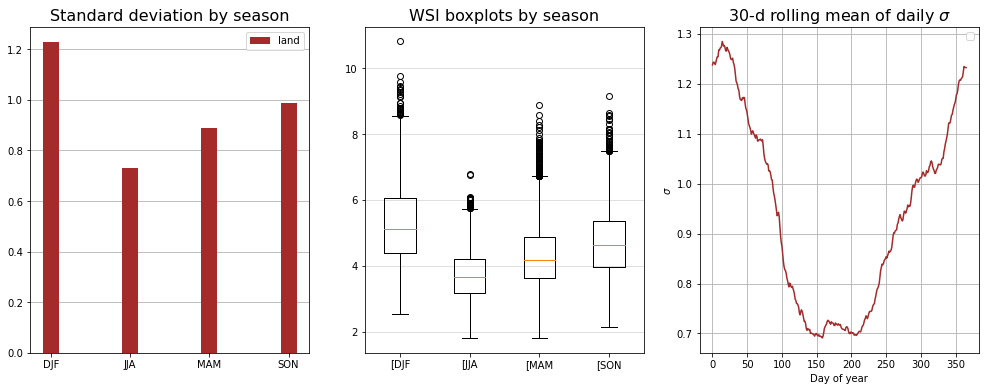

In [19]:
fig = plt.figure(figsize=(17, 6))

ax = fig.add_subplot(1, 3, 1)
ax.set_title('Standard deviation by season', fontsize = 16)
ax.bar(ws_index_sstd.season, ws_index_sstd.values, width = 0.2, zorder = 3, color = 'brown', label = 'land')
ax.grid(axis = 'y',zorder = 1)
ax.legend()

ax = fig.add_subplot(1, 3, 2)
ax.set_title('WSI boxplots by season', fontsize = 16)
bp=[]
for season in ws_index_sstd.season.values :
    bp.append(ws_index.ws.groupby('time.season')[season])
ax.boxplot(bp, labels = ['[DJF','[JJA','[MAM','[SON'])
ax.grid(axis = 'y', alpha = 0.5)

ax = fig.add_subplot(1, 3, 3)
ax.set_title('30-d rolling mean of daily $\sigma$', fontsize = 16)
ax.plot(ws_index_day_std, color = 'brown')
ax.set_ylabel('$\sigma$')

ax.set_xlabel('Day of year')
ax.grid()
ax.legend()

plt.show()

In [20]:
def smoother(dataset) :
    return xr.concat([
    dataset.roll(dayofyear=150, roll_coords= True).ws.rolling(dayofyear=30, center=True).mean().roll(dayofyear=-150, roll_coords= True)[:15],
    dataset.ws.rolling(dayofyear=30, center=True).mean().dropna('dayofyear'),
    dataset.roll(dayofyear=150, roll_coords= True).ws.rolling(dayofyear=30, center=True).mean().roll(dayofyear=-150, roll_coords= True)[-14:]],
    dim = 'dayofyear').to_dataset()

In [21]:
ws_index_day_mean = ws_index_day_mean.assign_coords({'date' : ('dayofyear', dates)}).drop_vars('dayofyear')

In [22]:
ws_index_dqtl = ws_index.groupby('time.dayofyear').quantile([0,0.1,0.3,0.5,0.7,0.9,1])

In [23]:
ws_index_dqtl_smooth = smoother(ws_index_dqtl)

In [24]:
try :
    ws_index_dqtl_smooth = ws_index_dqtl_smooth.assign_coords({'date' : ('dayofyear', dates)}).drop_vars('dayofyear')
except ValueError :
    print('Time var already changed (land)')

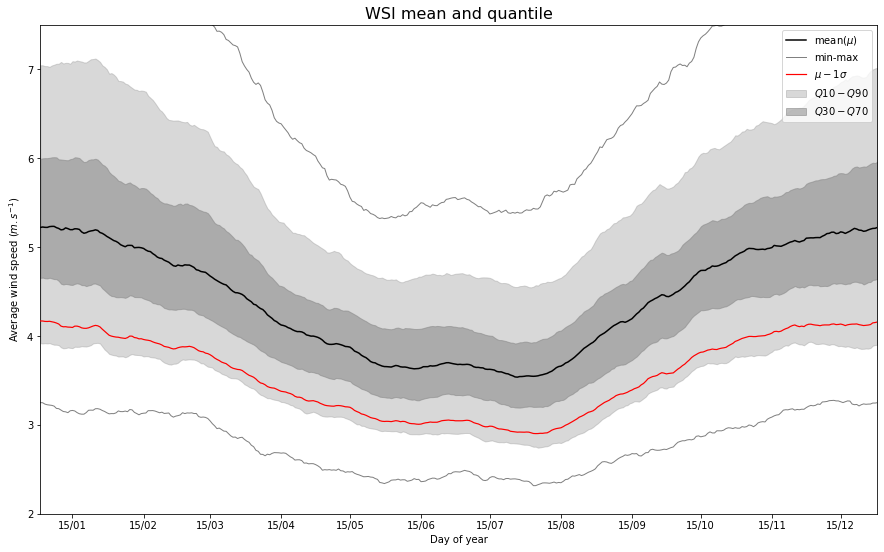

In [25]:
fig = plt.figure(figsize=(15, 9))

ax = fig.add_subplot(1, 1, 1)
ax.set_title('WSI mean and quantile', fontsize = 16)

ax.plot(ws_index_dqtl_smooth.sel(quantile = '0.5').ws, color = 'black',zorder = 2, label = 'mean($\mu$)')
ax.plot(ws_index_dqtl_smooth.sel(quantile = '0').ws, lw = 1, color = 'gray',zorder = 2)
ax.plot(ws_index_dqtl_smooth.sel(quantile = '1').ws, lw = 1, color = 'gray',zorder = 2, label = 'min-max')
ax.fill_between(ws_index_dqtl_smooth.date, ws_index_dqtl_smooth.sel(quantile = '0.1').ws, ws_index_dqtl_smooth.sel(quantile = '0.9').ws, color = 'gray', alpha = 0.3, zorder = 1, label = '$Q10-Q90$')
ax.fill_between(ws_index_dqtl_smooth.date, ws_index_dqtl_smooth.sel(quantile = '0.3').ws, ws_index_dqtl_smooth.sel(quantile = '0.7').ws, color = 'gray', alpha = 0.5, zorder = 1, label = '$Q30-Q70$')
ax.plot(ws_index_day_mean-ws_index_day_std, lw = 1.2, color = 'red', label = '$\mu - 1\sigma$', zorder = 3)
ax.set_ylim(2,7.5)

ax.set_xlabel('Day of year')
ax.xaxis.set_major_locator(x_locator)
ax.set_xlim(ws_index_dqtl_smooth.date[0], ws_index_dqtl_smooth.date[-1])
ax.set_ylabel('Average wind speed ($m.s^{-1}$)')
ax.legend(loc = 'upper right')

# plt.savefig('figs_wind/wsi_mean-q.jpeg')

plt.show()

### Detection using empirical WSI treshold

#### Simple spatial mean

In [26]:
WSI = ws_index.ws

WSI density plot

In [27]:
import scipy.stats as stats

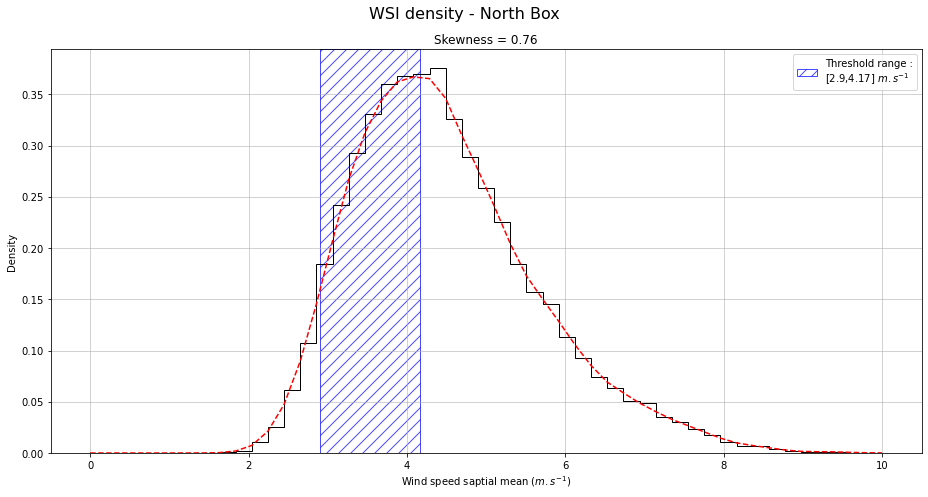

In [28]:
plt.figure(figsize = (13,7))
plt.suptitle('WSI density - North Box', fontsize = 16)
plt.title(f'Skewness = {round(stats.skew(WSI),3)}', fontsize = 12)
density = stats.gaussian_kde(WSI)
n, x, _ = plt.hist(WSI, bins = np.linspace(0,10,50), histtype=u'step', density=True, color = 'k', zorder = 2)  
plt.plot(x, density(x), color = 'r', ls = '--', zorder = 2)
threshlod_range = [np.min(ws_index_day_mean-ws_index_day_std), np.max(ws_index_day_mean-ws_index_day_std)]
range_label = f'Threshold range :\n[{round(float(threshlod_range[0].values),2)},{round(float(threshlod_range[1].values),2)}] $m.s^{{-1}}$'
plt.axvspan(threshlod_range[0], threshlod_range[1], color='b', alpha = 0.7, fill = False, hatch = '//', label = range_label, zorder = 1)

plt.grid(alpha = 0.7, zorder = 1)
# plt.xlim(0,5)
plt.xlabel('Wind speed saptial mean ($m.s^{-1}$)')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.savefig('figs_wind/N_box/Nbox_WSI_density.jpeg')
plt.show()

Treshold choice : $\mu-1\sigma$

In [29]:
annual_treshold = ws_index_day_mean-ws_index_day_std

In [30]:
def apply_threshold(WSI, annual_treshold, dropna = True) :
    years = range(1979, 2020)
    WSI_u2 = xr.DataArray(coords = dict(time = np.datetime64('1950-02-25')))

    for year in years :
        year_data = WSI.sel(time = slice(f'{year}-01-01T09:00:00.000000000', f'{year}-12-31T09:00:00.000000000'))

        if len(year_data) == 365 :
            filterd_data = year_data.where(year_data < annual_treshold.drop_sel(dayofyear = 60).values, drop = dropna)
            WSI_u2 = xr.concat([WSI_u2, filterd_data], dim = 'time')

        if len(year_data) == 366 :
            filterd_data_bis = year_data.where(year_data < annual_treshold.values, drop = dropna)
            WSI_u2 = xr.concat([WSI_u2, filterd_data_bis], dim = 'time')

    WSI_u2 = WSI_u2.drop_sel(time = '1950-02-25')
    return WSI_u2

In [31]:
WSI_u2 = apply_threshold(WSI, annual_treshold)
print(f'{len(WSI_u2)} days with WSI < annual_treshold on {len(WSI)} days available on data ({round(len(WSI_u2)/len(WSI)*100,2)}%)')

2436 days with WSI < annual_treshold on 14975 days available on data (16.27%)


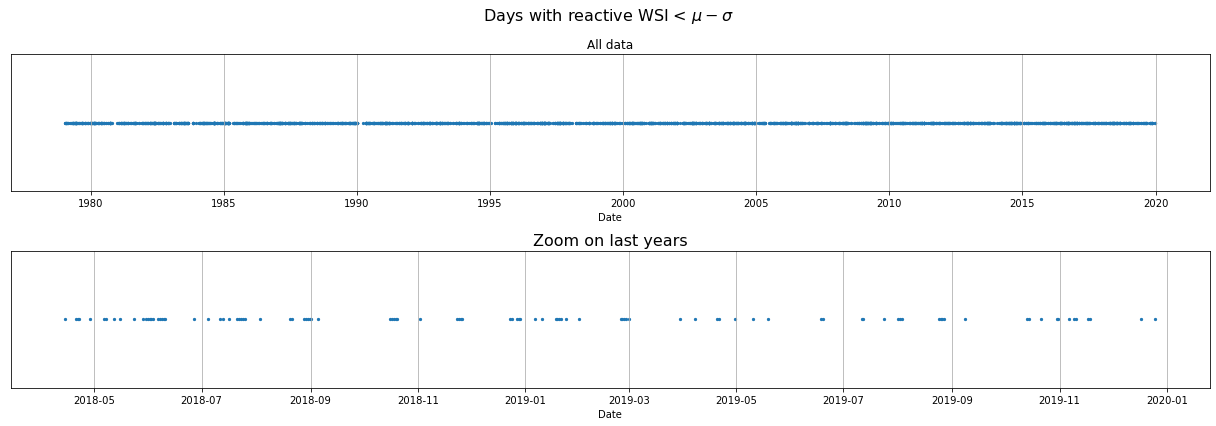

In [34]:
fig = plt.figure(figsize=(17, 6))

plt.suptitle('Days with reactive WSI < $\mu-\sigma$', fontsize = 16)
ax = fig.add_subplot(2, 1, 1)
ax.set_title('All data')
ax.set_xlabel('Date')
ax.set_yticks([])
ax.grid(axis = 'x')
ax.scatter(WSI_u2.time.values, [1]*len(WSI_u2), s = 5)

ax = fig.add_subplot(2, 1, 2)
ax.set_title('Zoom on last years', fontsize = 16)
ax.set_xlabel('Date')
ax.set_yticks([])
ax.grid(axis = 'x')
ax.scatter(WSI_u2.time.values[-100:], [1]*len(WSI_u2[-100:]), s = 5)

plt.tight_layout()
plt.show()

In [35]:
WSI_u2_density = apply_threshold(WSI, annual_treshold, dropna=False).groupby('time.dayofyear').count()

In [36]:
WSI_u2_smooth_density = xr.concat([
    WSI_u2_density.roll(dayofyear=150, roll_coords= True).rolling(dayofyear=30, center=True).mean().roll(dayofyear=-150, roll_coords= True)[:15],
    WSI_u2_density.rolling(dayofyear=30, center=True).mean().dropna('dayofyear'),
    WSI_u2_density.roll(dayofyear=150, roll_coords= True).rolling(dayofyear=30, center=True).mean().roll(dayofyear=-150, roll_coords= True)[-14:]],
    dim = 'dayofyear')

In [37]:
WSI_u2_smooth_density = WSI_u2_smooth_density.assign_coords({'date' : ('dayofyear', dates)}).drop_vars('dayofyear')
WSI_u2_density = WSI_u2_density.assign_coords({'date' : ('dayofyear', dates)}).drop_vars('dayofyear')

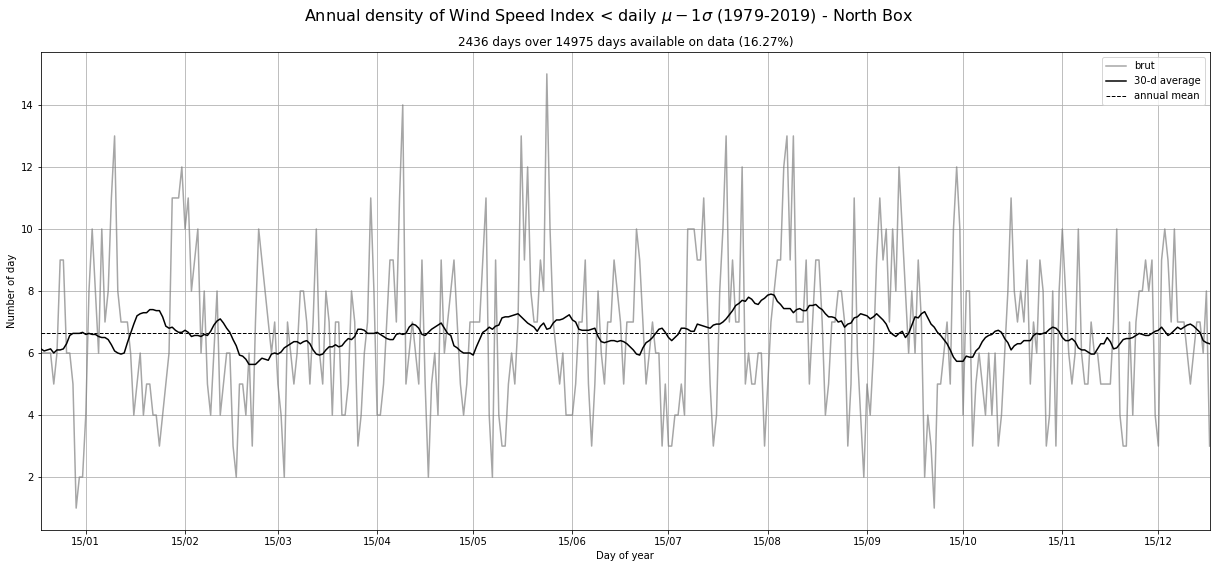

In [38]:
fig = plt.figure(figsize=(17, 8))

ax = fig.add_subplot(1, 1, 1)
plt.suptitle(f'Annual density of Wind Speed Index < daily $\mu - 1\sigma$ (1979-2019) - North Box', fontsize = 16)
ax.set_title(f'{len(WSI_u2)} days over {len(WSI)} days available on data ({round(len(WSI_u2)/len(WSI)*100,2)}%)')
ax.plot(WSI_u2_density.date.values, WSI_u2_density, color = 'gray', alpha = 0.7, zorder = 2, label = 'brut')
ax.plot(WSI_u2_density.date.values, WSI_u2_smooth_density, color = 'black', zorder = 3, label = '30-d average')
ax.axhline(WSI_u2_smooth_density.mean('dayofyear'), color = 'black', lw = 1, ls = '--', zorder = 1, label = 'annual mean')

ax.set_xlabel('Day of year')
ax.xaxis.set_major_locator(x_locator)
ax.set_xlim(WSI_u2_density.date.values[0], WSI_u2_density.date.values[-1])
ax.set_ylabel('Number of day')
ax.grid(zorder = 1)
ax.legend()
plt.tight_layout()
plt.show()

#### One-day outage filtration

In [39]:
WSI_u2_filter = WSI_u2

In [40]:
drop_count = 0
for index, WO_day in enumerate(WSI_u2.time.dt.date.values) :
    try :
        if not (WO_day.toordinal() - 1 == WSI_u2.time.dt.date.values[index - 1].toordinal() or WO_day.toordinal() + 1 == WSI_u2.time.dt.date.values[index + 1].toordinal()) :
            WSI_u2_filter = WSI_u2_filter.drop_sel(time = str(WSI_u2[index].time.values))
            print(f'Dropping {WSI_u2[index].time.values}', end = '\r')
            drop_count+=1
    except IndexError :
        pass #start and end raise this error
print(f'{drop_count} days dropped                      ')

647 days dropped                      


In [41]:
blank = WSI.where(WSI == False).groupby('time.dayofyear').count().drop_sel(dayofyear = WSI_u2_filter.groupby('time.dayofyear').count().dayofyear.values)

In [42]:
WSI_u2_filter_density = blank.combine_first(WSI_u2_filter.groupby('time.dayofyear').count())

In [43]:
WSI_u2_filter_smooth_density = xr.concat([
    WSI_u2_filter_density.roll(dayofyear=150, roll_coords= True).rolling(dayofyear=30, center=True).mean().roll(dayofyear=-150, roll_coords= True)[:15],
    WSI_u2_filter_density.rolling(dayofyear=30, center=True).mean().dropna('dayofyear'),
    WSI_u2_filter_density.roll(dayofyear=150, roll_coords= True).rolling(dayofyear=30, center=True).mean().roll(dayofyear=-150, roll_coords= True)[-14:]],
    dim = 'dayofyear')

In [44]:
WSI_u2_filter_smooth_density = WSI_u2_filter_smooth_density.assign_coords({'date' : ('dayofyear', dates)}).drop_vars('dayofyear')
WSI_u2_filter_density = WSI_u2_filter_density.assign_coords({'date' : ('dayofyear', dates)}).drop_vars('dayofyear')

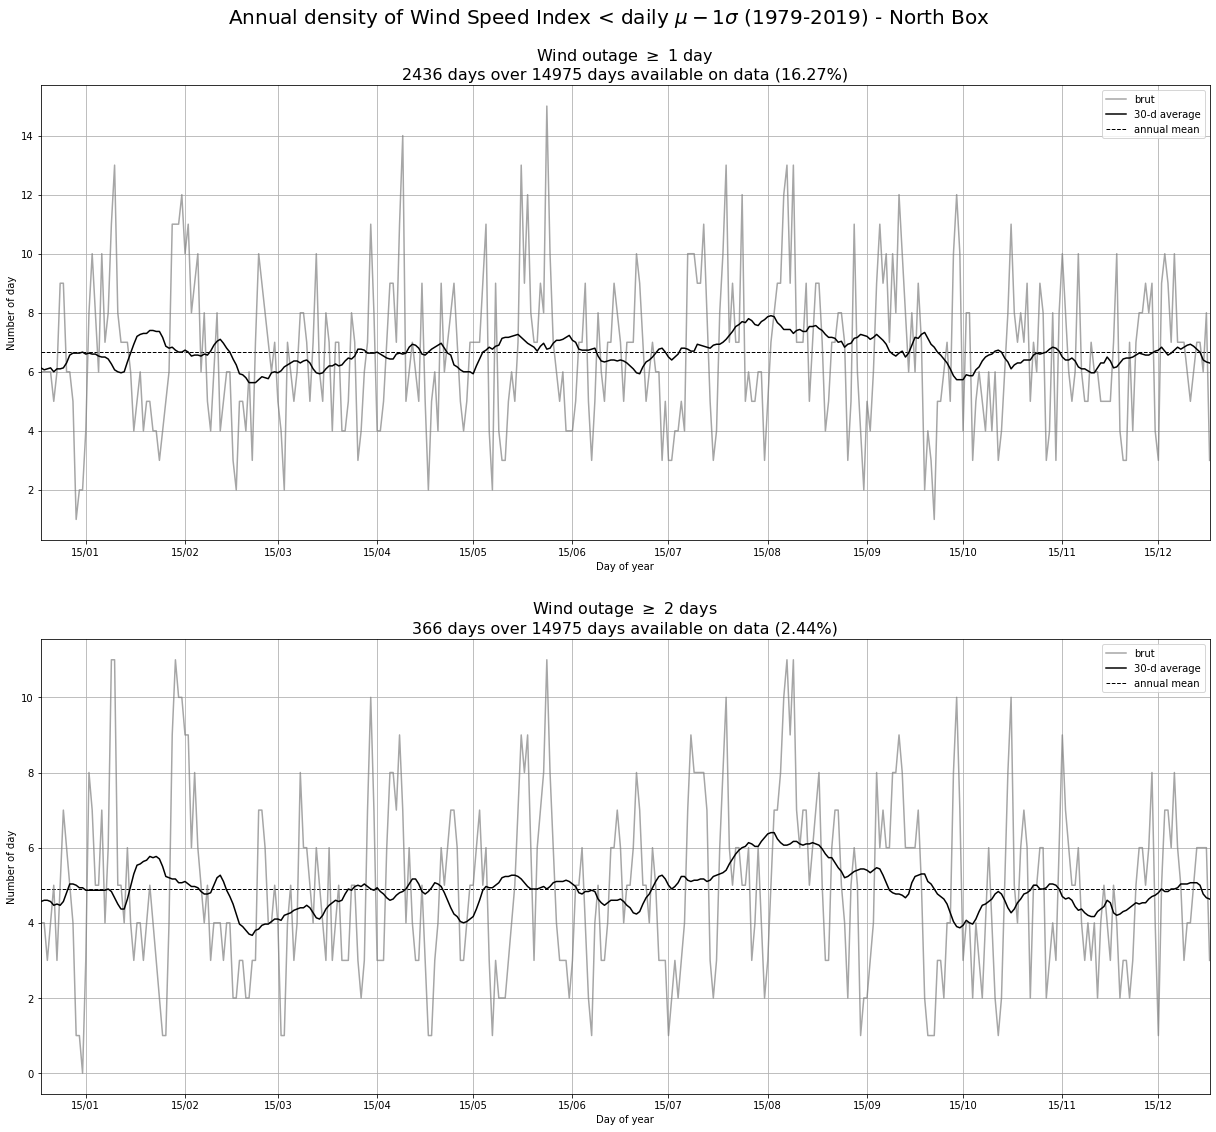

In [45]:
fig = plt.figure(figsize=(17, 16))

ax = fig.add_subplot(2, 1, 1)
ax.set_title(f'\nWind outage $\geq$ 1 day\n{len(WSI_u2)} days over {len(WSI)} days available on data ({round(len(WSI_u2)/len(WSI)*100,2)}%)',fontsize = 16)
ax.plot(WSI_u2_density.date.values, WSI_u2_density, color = 'gray', alpha = 0.7, zorder = 2, label = 'brut')
ax.plot(WSI_u2_density.date.values, WSI_u2_smooth_density, color = 'black', zorder = 3, label = '30-d average')
ax.axhline(WSI_u2_smooth_density.mean('dayofyear'), color = 'black', lw = 1, ls = '--', zorder = 1, label = 'annual mean')

ax.set_xlabel('Day of year')
ax.xaxis.set_major_locator(x_locator)
ax.set_xlim(WSI_u2_density.date.values[0], WSI_u2_density.date.values[-1])
ax.set_ylabel('Number of day')
ax.grid(zorder = 1)
ax.legend()

ax = fig.add_subplot(2, 1, 2)
ax.set_title(f'\nWind outage $\geq$ 2 days\n{len(WSI_u2_filter_density)} days over {len(WSI)} days available on data ({round(len(WSI_u2_filter_density)/len(WSI)*100,2)}%)',fontsize = 16)
ax.plot(WSI_u2_filter_density.date.values, WSI_u2_filter_density, color = 'gray', alpha = 0.7, zorder = 2, label = 'brut')
ax.plot(WSI_u2_filter_density.date.values, WSI_u2_filter_smooth_density, color = 'black', zorder = 3, label = '30-d average')
ax.axhline(WSI_u2_filter_density.mean('dayofyear'), color = 'black', lw = 1, ls = '--', zorder = 1, label = 'annual mean')

ax.set_xlabel('Day of year')
ax.xaxis.set_major_locator(x_locator)
ax.set_xlim(WSI_u2_filter_density.date.values[0], WSI_u2_filter_density.date.values[-1])
ax.set_ylabel('Number of day')
ax.grid(zorder = 1)
ax.legend()


plt.suptitle(f'Annual density of Wind Speed Index < daily $\mu - 1\sigma$ (1979-2019) - North Box', fontsize = 20)
plt.tight_layout()
plt.savefig('figs_wind/N_box/Nbox_density.jpeg')
plt.show()